GASSION Axel  
GAUFRETEAU Simon

Tiré de : https://www.kaggle.com/ariosliew92/energy-efficiency-linear-regression/notebook

# Imports & Prévisualisation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor as rf_reg
from sklearn.model_selection import RandomizedSearchCV as randomCV
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression as l_reg
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,confusion_matrix,accuracy_score,precision_score
from sklearn import metrics
from plotnine import *
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import utils
import pprint

print("Import OK")

Import OK


## Import data / print head

In [3]:
energy_df=pd.read_csv('./data/ENB2012_data.csv')
energy_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


## Rename columns

In [4]:
energy_df.columns=["relative_compactness","surface_area","wall_area","roof_area","overall_height","orientation",
                   "glazing_area","glazing_area_dist","heating_load","cooling_load"]
features=list(energy_df.columns)
features.remove("heating_load")
features.remove("cooling_load")
print(features)
energy_df.head()

['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height', 'orientation', 'glazing_area', 'glazing_area_dist']


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_dist,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


# Data Transformation

In [5]:
# Vérifier que certains champs ne soient pas vides ou ne contiennent pas de données que l'on voudrait filtrer

energy_df.describe()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_dist,heating_load,cooling_load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


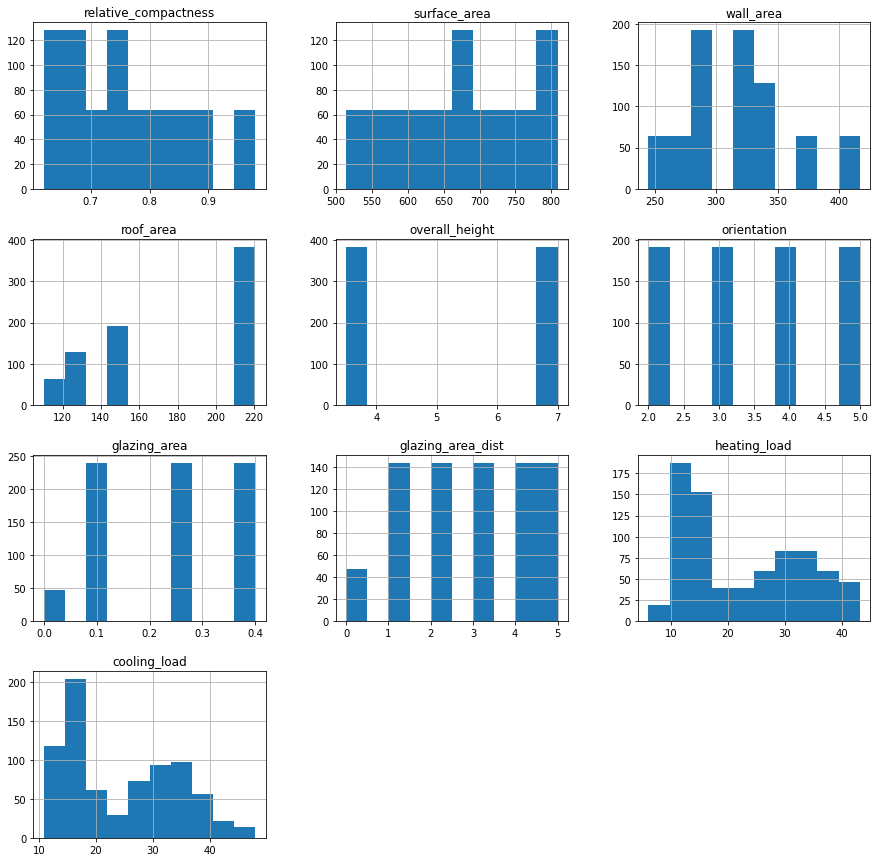

In [6]:
energy_df.hist(figsize=(15,15))
plt.show()

Comme on veut travailler sur *cooling_load* et *heating_load*, et que l'on a une concentration d'un seul côté, la personne qui a travaillé sur le notebook que nous utilisons comme référence a décidé d'appliquer un log pour étendre plus la distribution

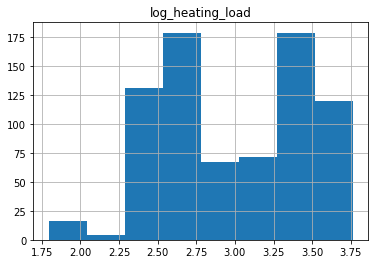

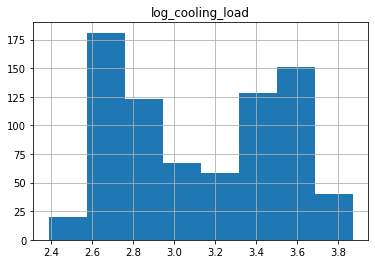

In [7]:
energy_df["log_heating_load"]=np.log(energy_df["heating_load"])
energy_df["log_cooling_load"]=np.log(energy_df["cooling_load"])

energy_df["log_heating_load"].hist(bins=8)
plt.title("log_heating_load")
plt.show()

energy_df["log_cooling_load"].hist(bins=8)
plt.title("log_cooling_load")
plt.show()

# Data Treatment

Certaines fonctions d'analyse des features ont été implémentées et utilisées. Cependant, nous avons décidé de garder une liste fixe des features que nous utliserons pour analyser les deux variables voulues.
Cette liste est issue du kaggle qui nous a servi d'inspiration.

## Split data into training and testing sets

In [8]:
final_feature_list=["relative_compactness","overall_height","glazing_area","wall_area","roof_area","surface_area"]

energy_df_f=energy_df.copy()
energy_df_f.drop(["heating_load","cooling_load"],axis=1,inplace=True)

#Variables heating / train test split
energy_X=energy_df_f.iloc[:,:-2]
energy_Y=energy_df_f.loc[:,["log_heating_load"]]
energy_train_X,energy_test_X,energy_train_Y,energy_test_Y=\
train_test_split(energy_X,energy_Y,test_size=0.20,random_state=48)

#Variables cooling / train test split
energy2_X=energy_df_f.iloc[:,:-2]
energy2_Y=energy_df_f.loc[:,["log_cooling_load"]]
energy2_train_X,energy2_test_X,energy2_train_Y,energy2_test_Y=\
train_test_split(energy2_X,energy2_Y,test_size=0.20,random_state=48)

## Functions

### Features selection functions

Cette fonction affiche un graphique montrant l'importance des features, en utilisant un RandomForestClassifier

In [9]:
def variableImportance(X_train,X_test,Y_train,Y_test,features):
    SS=StandardScaler()
    SS.fit(X_train)
    features=np.array(features)
    X_train_norm=SS.transform(X_train)
    X_test_norm=SS.transform(X_test)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train_norm, Y_train)
    importances=clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
    sorted_idx = np.argsort(importances)[::-1]
    padding = np.arange(X_train_norm.size/len(X_train_norm)) + 0.5
    plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
    plt.yticks(padding, features[sorted_idx])
    plt.xlabel("Relative Importance")
    plt.title("Variable Importance")
    plt.show()

Cette fonction effectue un GridSearch à partir de l'entrainement d'un RandomForestRegressor.
Son but est de trouver certains paramètres optimaux comme le nombre de features que l'on pourrait utiliser pour entrainer notre modèle.

Malheureusement son intérêt n'est pas très élevé dans cette situation à cause du faible nombre de features disponibles (8).
Il est plus intéressant d'utiliser un RandomForestClassifier et de prendre les meilleures features, tout en prenant en compte certains paramètres qui ont une forte corrélation.

In [10]:
def gridSearch(X_train,X_test,Y_train,Y_test,features):
    SS=StandardScaler()
    SS.fit(X_train)
    features=np.array(features)
    X_train_norm=SS.transform(X_train)
    X_test_norm=SS.transform(X_test)
    
    # Create the parameter grid based on the results of random search 
    param_grid = {
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': [3,4,5,6],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200]
    }
    # Create a based model
    rf = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)
        # Fit the grid search to the data
    grid_search.fit(X_train_norm, Y_train)
    print(grid_search.best_params_)
    best_grid = grid_search.best_estimator_

### Final features

On calcule ici un score pour chacune des features

In [11]:
def ffeatures(train_X,train_Y,feature_list,maxparam):
    predictor_var = feature_list
    model = RandomForestClassifier(n_estimators=25,min_samples_split=25, max_depth=10) # More parameters to avoid over-fitting
    model.fit(train_X,train_Y)

    predictions = model.predict(train_X)
    accuracy = metrics.accuracy_score(predictions,train_Y)
    #print(model.feature_importances_)
    featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
    print(featimp[:maxparam])


### Cross validation function

Calculs de RMSE et R2_score moyens pour les features choisies -- Pas utile pour la régression linéaire mais intéressant

In [12]:
def l_reg_cv(train_X,train_Y,feature_list):
    rmse_list_train=[]
    rmse_list_test=[]
    r2_list_train=[]
    r2_list_test=[]
    for i in range(1,len(feature_list)+1):
        train_X_temp=train_X.loc[:,feature_list[:i]]
        cv_results_temp = cross_validate(l_reg(), train_X.loc[:,final_feature_list[:i]],train_Y, 
                            cv=5,scoring=["neg_root_mean_squared_error","r2"],return_train_score=True)
        mean_rmse_train=np.mean(cv_results_temp["train_neg_root_mean_squared_error"])
        mean_r2_train=np.mean(cv_results_temp["train_r2"])
        mean_rmse_test=np.mean(cv_results_temp["test_neg_root_mean_squared_error"])
        mean_r2_test=np.mean(cv_results_temp["test_r2"])
        rmse_list_train.append(mean_rmse_train)
        r2_list_train.append(mean_r2_train)
        rmse_list_test.append(mean_rmse_test)
        r2_list_test.append(mean_r2_test)
        rmse_df=pd.DataFrame(zip(rmse_list_train,rmse_list_test,r2_list_train,r2_list_test))
        rmse_df.columns=["Mean RMSE Train","Mean RMSE Test","Mean R2 Train","Mean R2 Test"]
        rmse_df.index=rmse_df.index+1
    return rmse_df

### Plot function

Fonction graphique pour traver les Scatter plot Train et Test avec valeurs/prédictions

In [13]:
def predictVSactual(actual_y,y_predict,title_label):
    fig,ax=plt.subplots(1,len(actual_y),figsize=(15,15))
    for i,col in enumerate(actual_y,0):
        ax[i].plot(np.ravel(actual_y[i]),
                   np.ravel(y_predict[i]),'o',markeredgecolor="black")
        ax[i].set_title(title_label[i])
        ax[i].set_xlabel('Actual Values')
        ax[i].set_ylabel('Predicted Values')
        ax[i].set(aspect='equal')
        x=ax[i].get_xlim()
        y=ax[i].get_xlim()
        ax[i].plot(x,y, ls="--", c=".3")
    return fig,ax

### Executable function

Une RMSE faible traduit une variance faible entre les valeurs actuelles et les valeurs prédites.  
R2 correspond au coefficient de détermination linéaire, plus il est proche de 1, meilleure est la régression.  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [14]:
resTabHOT = {}
resTabCOLD = {}

def predictPrintRes(model,model_type,energy_train_X,energy_test_X,energy_train_Y,energy_test_Y,feat):
    
    print("Pour un {model}".format(model=model_type))
    model.fit(energy_train_X.loc[:,final_feature_list[:5]],np.ravel(energy_train_Y))
    pred_train_Y_best=model.predict(energy_train_X.loc[:,final_feature_list[:5]])
    pred_test_Y_best=model.predict(energy_test_X.loc[:,final_feature_list[:5]])
    
    RMSETrain = MSE(pred_train_Y_best,energy_train_Y,squared=False)
    RMSETest = MSE(pred_test_Y_best,energy_test_Y,squared=False)
    print("RMSE for Train set:",RMSETrain)
    print("RMSE for Test set:",RMSETest)
    
    R2Train = r2_score(pred_train_Y_best,energy_train_Y)
    R2Test = r2_score(pred_test_Y_best,energy_test_Y)
    print("R2 for Train set:",R2Train)
    print("R2 for Test set:",R2Test)
    
    if feat == "HOT":
        resTabHOT['RMSETrain-{model}'.format(model=model_type)] = round(RMSETrain,4)
        resTabHOT['RMSETest-{model}'.format(model=model_type)] = round(RMSETest,4)
        resTabHOT['R2Train-{model}'.format(model=model_type)] = round(R2Train,4)
        resTabHOT['R2Test-{model}'.format(model=model_type)] = round(R2Test,4)
    else:
        resTabCOLD['RMSETrain-{model}'.format(model=model_type)] = round(RMSETrain,4)
        resTabCOLD['RMSETest-{model}'.format(model=model_type)] = round(RMSETest,4)
        resTabCOLD['R2Train-{model}'.format(model=model_type)] = round(R2Train,4)
        resTabCOLD['R2Test-{model}'.format(model=model_type)] = round(R2Test,4)
    
    actual_y_energy=[energy_train_Y,energy_test_Y]
    pred_y_energy=[pred_train_Y_best,pred_test_Y_best]
    predictVSactual(actual_y_energy,pred_y_energy,
                    ["Scatter Plot: Prediction Comparison (Train)","Scatter Plot: Prediction Comparison (Test)"])
    plt.show()

In [15]:
def predictReg(energy_train_X,energy_test_X,energy_train_Y,energy_test_Y,feat):

    l_reg_best=l_reg()
    predictPrintRes(l_reg_best,"Linear regressor",energy_train_X,energy_test_X,energy_train_Y,energy_test_Y,feat)
    
    rf = RandomForestRegressor()
    predictPrintRes(rf,"RandomForest regressor",energy_train_X,energy_test_X,energy_train_Y,energy_test_Y,feat)
    
    knR = KNeighborsRegressor()
    predictPrintRes(knR,"KNeighbors regressor",energy_train_X,energy_test_X,energy_train_Y,energy_test_Y,feat)
      

## LinearRegression avec heating_load

### Variables/Features

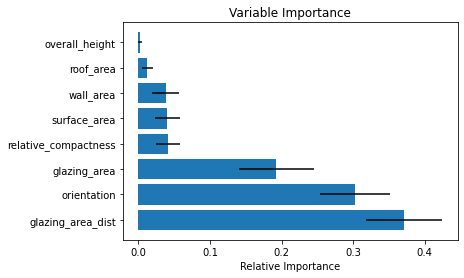

Fitting 3 folds for each of 288 candidates, totalling 864 fits
{'bootstrap': True, 'max_depth': 110, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


,Mean RMSE Train,Mean RMSE Test,Mean R2 Train,Mean R2 Test
1,-0.362498,-0.362583,0.423217,0.417459
2,-0.190841,-0.191884,0.840152,0.837311
3,-0.130170,-0.130528,0.925626,0.924653
4,-0.119656,-0.119957,0.937152,0.936287
5,-0.119151,-0.119537,0.937681,0.936732
6,-0.119151,-0.119534,0.937681,0.936735
7,-0.119151,-0.119534,0.937681,0.936735
8,-0.119151,-0.119534,0.937681,0.936735


In [16]:
lab_enc = preprocessing.LabelEncoder()
Y_train_encoded = lab_enc.fit_transform(energy_train_Y.values.ravel())
Y_test_encoded = lab_enc.fit_transform(energy_test_Y.values.ravel())

variableImportance(energy_train_X,energy_test_X,Y_train_encoded,Y_test_encoded,features)
gridSearch(energy_train_X,energy_test_X,Y_train_encoded,Y_test_encoded,features)
l_reg_cv(energy_train_X,energy_train_Y,features)

### Modèles de régression

Pour un Linear regressor
RMSE for Train set: 0.11922889467600066
RMSE for Test set: 0.13376486227336667
R2 for Train set: 0.9334914255748193
R2 for Test set: 0.9103904558887782


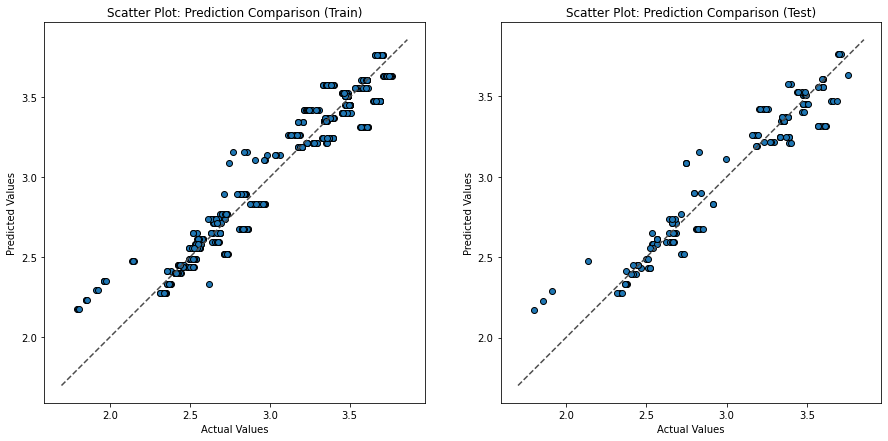

Pour un RandomForest regressor
RMSE for Train set: 0.022417649863415396
RMSE for Test set: 0.024266536414457848
R2 for Train set: 0.9977899976285965
R2 for Test set: 0.9973233049790923


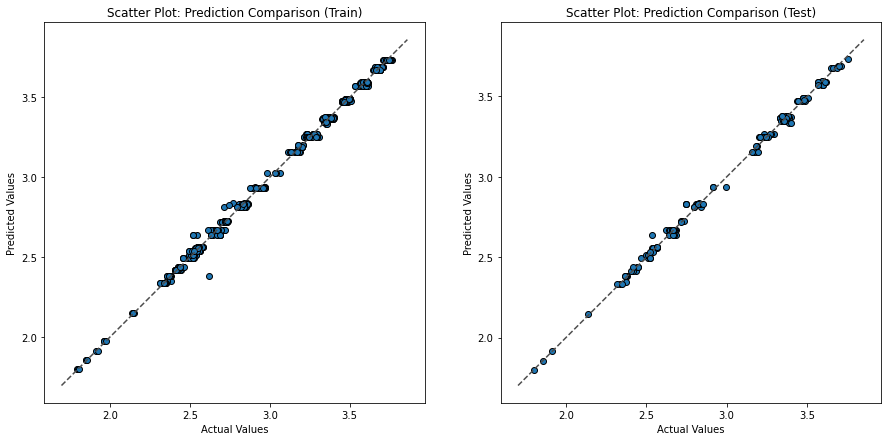

Pour un KNeighbors regressor
RMSE for Train set: 0.04438196054385831
RMSE for Test set: 0.06639810071943213
R2 for Train set: 0.9909612922745668
R2 for Test set: 0.9789414051452929


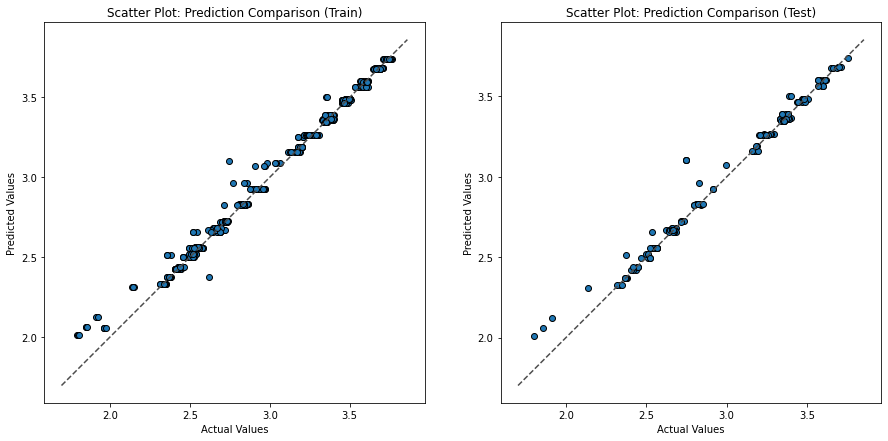

In [17]:
predictReg(energy_train_X,energy_test_X,energy_train_Y,energy_test_Y,"HOT")

## LinearRegression avec cooling_load

### Variables/Features

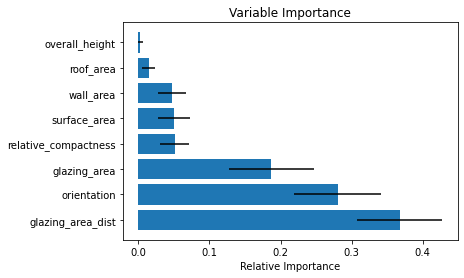

Fitting 3 folds for each of 288 candidates, totalling 864 fits
{'bootstrap': True, 'max_depth': 100, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


,Mean RMSE Train,Mean RMSE Test,Mean R2 Train,Mean R2 Test
1,-0.290515,-0.290509,0.451712,0.447037
2,-0.139979,-0.140843,0.872678,0.869640
3,-0.112064,-0.112501,0.918384,0.916640
4,-0.109113,-0.109899,0.922627,0.920478
5,-0.108934,-0.109792,0.922880,0.920627
6,-0.108945,-0.109821,0.922866,0.920584
7,-0.108945,-0.109821,0.922866,0.920584
8,-0.108945,-0.109821,0.922866,0.920584


In [18]:
lab_enc = preprocessing.LabelEncoder()
Y2_train_encoded = lab_enc.fit_transform(energy2_train_Y.values.ravel())
Y2_test_encoded = lab_enc.fit_transform(energy2_test_Y.values.ravel())

variableImportance(energy2_train_X,energy2_test_X,Y2_train_encoded,Y2_test_encoded,features)
gridSearch(energy2_train_X,energy2_test_X,Y2_train_encoded,Y2_test_encoded,features)
l_reg_cv(energy2_train_X,energy2_train_Y,features)

### Modèles de Régression

Pour un Linear regressor
RMSE for Train set: 0.1090674533609917
RMSE for Test set: 0.12190297511095048
R2 for Train set: 0.9162985276981366
R2 for Test set: 0.8895421903026551


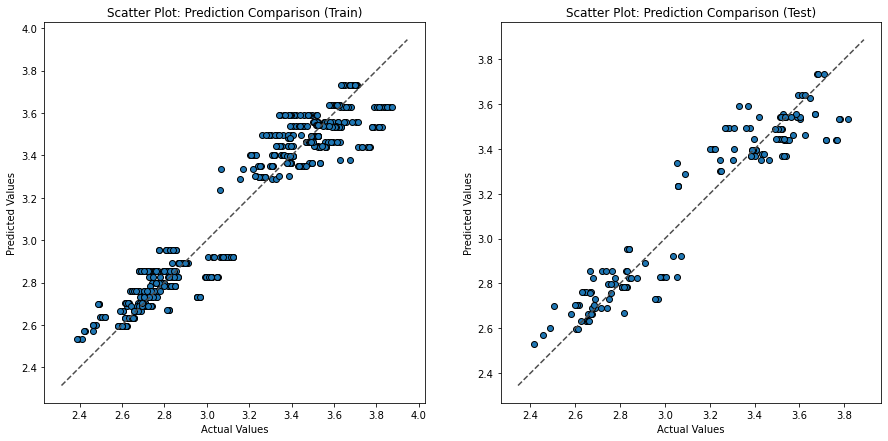

Pour un RandomForest regressor
RMSE for Train set: 0.04642427306009957
RMSE for Test set: 0.06141631818923089
R2 for Train set: 0.9857993313035358
R2 for Test set: 0.9744864388750731


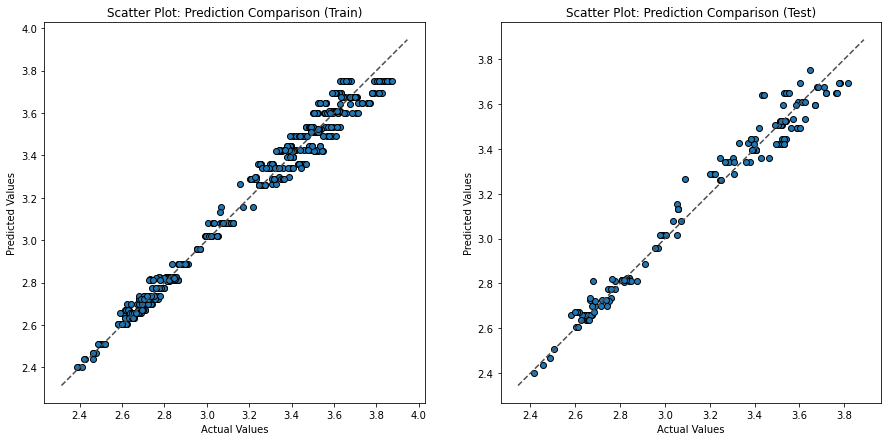

Pour un KNeighbors regressor
RMSE for Train set: 0.05057668339147042
RMSE for Test set: 0.06925358302911759
R2 for Train set: 0.9824684578154822
R2 for Test set: 0.9658383621827522


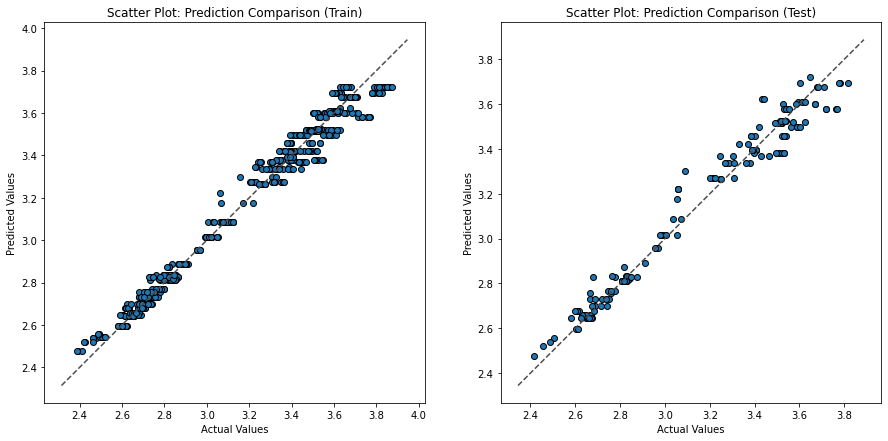

In [19]:
predictReg(energy2_train_X,energy2_test_X,energy2_train_Y,energy2_test_Y,"COLD")

# Conclusion

In [59]:
print("Résultats pour heating_load")
val = np.reshape(np.array(list(resTabHOT.values())),(-1,4))
series = pd.DataFrame(val,columns=["RMSE Train","RMSE Test","R2 Train","R2 Test"],index=["Linear","RF","KN"]) #["Linear","RF","KN"]
print(series)
print("\nRésultats pour cooling_load")
val = np.reshape(np.array(list(resTabCOLD.values())),(-1,4))
series = pd.DataFrame(val,columns=["RMSE Train","RMSE Test","R2 Train","R2 Test"],index=["Linear","RF","KN"]) #["Linear","RF","KN"]
print(series)

Résultats pour heating_load
        RMSE Train  RMSE Test  R2 Train  R2 Test
Linear      0.1192     0.1338    0.9335   0.9104
RF          0.0224     0.0243    0.9978   0.9973
KN          0.0444     0.0664    0.9910   0.9789

Résultats pour cooling_load
        RMSE Train  RMSE Test  R2 Train  R2 Test
Linear      0.1091     0.1219    0.9163   0.8895
RF          0.0464     0.0614    0.9858   0.9745
KN          0.0506     0.0693    0.9825   0.9658


On peut remarquer que le modèle de régression linéaire est efficace pour les deux features sur lesquelles nous avons travaillé.
En effet, le rapport entre les scores obtenus entre les données de test et les données d'entrainement est suffisement faible pour que l'on puisse dire que le modèle semble bien entrainé et efficace.  
Cependant elle à l'air limitée comparée aux deux autres modèles de régression (KNeighbors et RandomForest) qui donnent des résultats très convaincants.

La régression linéaire a donc l'air d'être un modèle adapté et intéressant à utiliser dans certaines situations lorsqu'il est bien entrainé.